In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from sklearn.model_selection import train_test_split

In [2]:
masks = pd.read_csv(os.path.join('input/', 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

3231 masks in 1615 images
5791 empty images in 7406 total images


,Unnamed: 0,ImageId,EncodedPixels
0,0,00003e153.jpg,NaN
1,1,0001124c7.jpg,NaN
2,2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [3]:
ship_dir = 'datasets'
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')

In [8]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
masks.drop(['ships'], axis=1, inplace=True)

<AxesSubplot:>

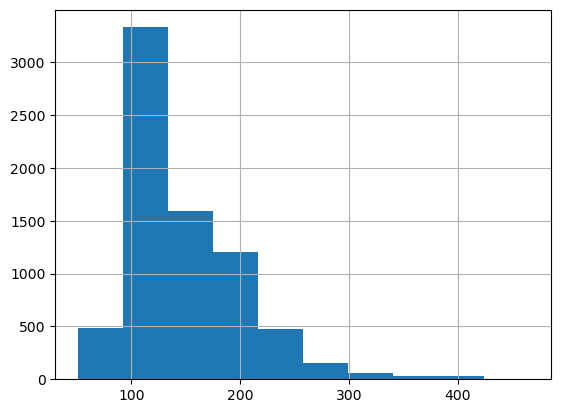

In [9]:
unique_img_ids['file_size_kb'].hist()

<AxesSubplot:>

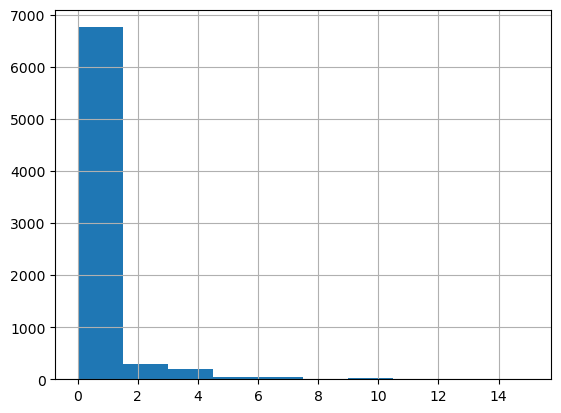

In [10]:

unique_img_ids['ships'].hist()

#Here is a problem - too many images dont have any ships.

In [13]:

SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
print(balanced_train_df.shape[0], 'masks')

3599 masks


<AxesSubplot:>

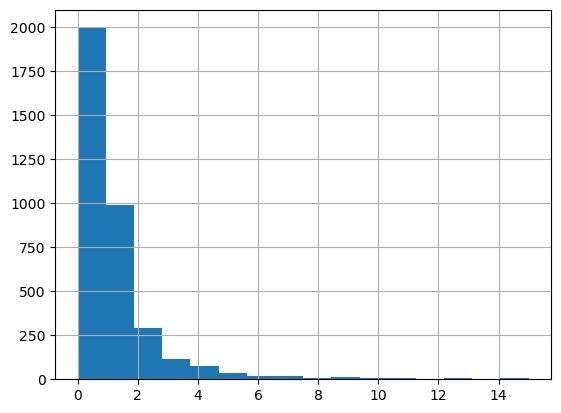

In [15]:
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)

In [14]:
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

4164 training masks
1040 validation masks
